# Binary logistic regression with Polya-Gamma augmentation

In [1]:
using LinearAlgebra
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/GithubRepositories/BayesianModels/Project.toml`
┌ Info: Precompiling BayesianModels [56ff943f-52c4-4398-bcf1-974dffc1fcd6]
└ @ Base loading.jl:1260


### Synthetic data

(120,)


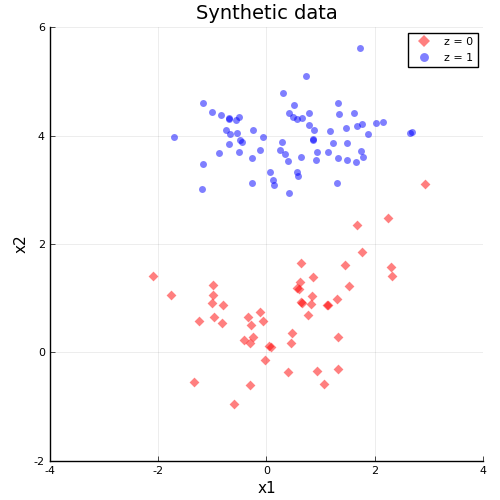

In [2]:
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]

μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 10

x1 = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2 = samplenormal(μ3, Σ3, 7  * sizecoeff)
X = hcat(x1, x2)
z = vcat(zeros(Int64, size(x1, 2)), ones(Int64, size(x2, 2)))
println(size(z))

p = plot(
    title="Synthetic data", 
    size=(500, 500),
    xlims=(-4, 4),
    ylims=(-2, 6),
    aspect_ratio=:equal, 
    xlabel="x1", 
    ylabel="x2"
)

scatter!(
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, stroke(0))
)

scatter!(
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, stroke(0)), 
)


In [3]:
function fit!(model, X, z; nsteps = 100)
    elbos = [elbo(model, X, z) / length(z)]

    for step in 1:nsteps    
        stats = (X, z) |> model.β.stats
        accstats = dropdims(sum(stats, dims = 2), dims=2)
        
        update!(model.β.posterior, naturalparam(model.β.prior) + accstats)

        push!(elbos, elbo(model, X, z) / length(z))   
    end
    elbos
end

fit! (generic function with 1 method)

In [11]:
model1 = BinaryLogisticRegression(
    inputdim = size(X, 1),
    hasbias = true,
    pseudocounts = 1
)

elbos1 = fit!(model1, X, z, nsteps = 20)

21-element Array{Float64,1}:
 -1.6851132847778263
 -0.22699450116238443
 -0.21114064912279099
 -0.20815981957480853
 -0.20752352988660228
 -0.20738014447863326
 -0.20734620582922222
 -0.20733752027996916
 -0.2073349762064096
 -0.20733407546713872
 -0.20733368983077913
 -0.20733350097437916
 -0.20733340149323637
 -0.20733334729340516
 -0.20733331733556562
 -0.20733330067878028
 -0.20733329139550322
 -0.207333286216882
 -0.20733328332700993
 -0.20733328171415372
 -0.2073332808139772

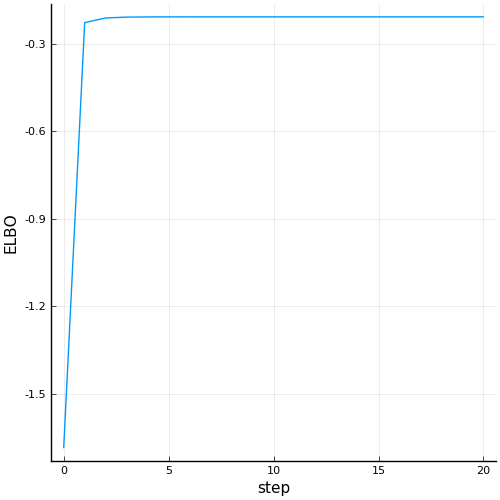

In [12]:
ptraining = plot(
    0:(length(elbos1) - 1), elbos1,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

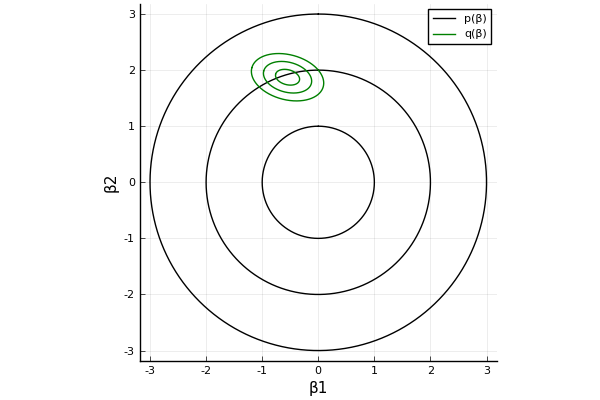

In [13]:
model = model1 

μ₀ = model.β.prior.μ
Σ₀ = model.β.prior.Σ
μᵦ = model.β.posterior.μ
Σᵦ = model.β.posterior.Σ

ppost = plot(
    #xlims = (-50, 50),
    #ylims = (-50, 50),
    aspect_ratio=:equal,
    xlabel = "β1",
    ylabel = "β2",
)
plotnormal2d(ppost, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 3, color = :black, label="p(β)")
plotnormal2d(ppost, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :green, label="q(β)")

### Visualisation

In [14]:
function sampleβ(μ, Σ)
    L = cholesky(Σ).L
    μ .+ L * randn(length(μ))
end

function plotdecisionline!(p, w, w₀; plotting_radius=10, args...)
    # Normalize vector of weights
    norm_w = w ./ sqrt(sum(w.^2))

    # Angle of the weight vector in the range [0,2 π]
    θ = atan(w[2], w[1]) + π

    # Vector perpendicular to "w" with unit length.
    w⊥ = [cos(θ + π/2), sin(θ + π/2)]

    # Translation vector of  the decision boundary induced
    # by the bias
    shift = -(w₀ / sqrt(sum(w.^2))) * norm_w

    # Angle of the decision line in the range [0, 2π]
    α = atan(w⊥[2], w⊥[1]) + π
    
    # To get the decision line we rotate and shift the 
    # abscissa
    R = [cos(α) -sin(α); sin(α) cos(α)]
    decisionline = vcat(range(-plotting_radius, plotting_radius, length=1000)', zeros(1000)') 
    decisionline = R * decisionline .+ shift
    
    plot!(p, decisionline[1, :], decisionline[2, :]; args...)
end

plotdecisionline! (generic function with 1 method)

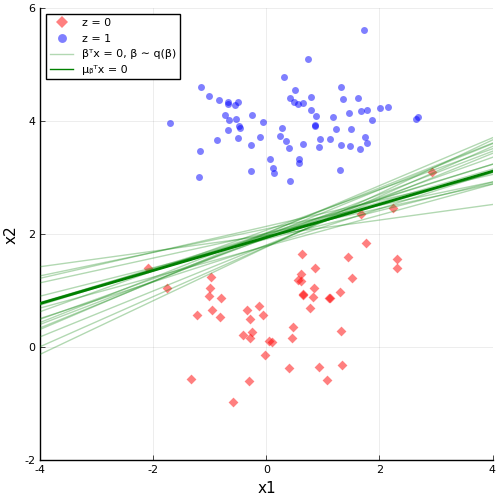

In [15]:
model = model1 

μᵦ = model.β.posterior.μ
Σᵦ = model.β.posterior.Σ

pdec = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-4, 4),
    ylims=(-2, 6),
    xlabel="x1", 
    ylabel="x2"
)

scatter!(pdec,
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, 0.5, stroke(0))
)

scatter!(pdec,
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, 0.5, stroke(0)), 
)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

pdec

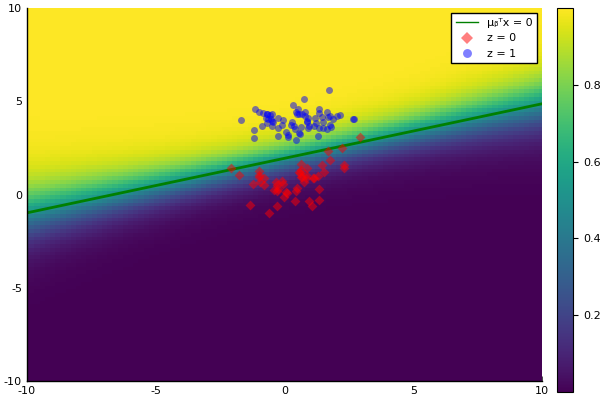

In [16]:
model = model1 

res = 100
dim1 = range(-10, 10, length=res)
dim2 = range(-10, 10, length=res)
testX = vec([ [i, j] for i=dim1, j=dim2])
testX = hcat(testX...)

testz1 = ones(size(testX, 2))
pz1 = predict(model, testX)

pz1grid = reshape(pz1, res, res)
ppredict = heatmap(
    dim1, 
    dim2,
    pz1grid',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = :viridis
)
w = μᵦ[1:2]
w₀ = μᵦ[end]
plotdecisionline!(ppredict, w, w₀, plotting_radius=20, 
                  line = (:green), linewidth=2, label="μᵦᵀx = 0")

scatter!(ppredict,
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, 0.5, stroke(0))
)

scatter!(ppredict,
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, 0.5, stroke(0)), 
)

## Posterior with isotropic covariance matrix

In [20]:
model2 = BinaryLogisticRegressionIso(
    inputdim = size(X, 1),
    hasbias = true,
    pseudocounts = 1
)

#elbos2 = fit!(model2, X, z, nsteps = 1)
model2(X, z)

120-element Array{Float64,1}:
 -0.8125257390206422
 -0.8396747986480562
 -0.784922301021199
 -0.8147391465223035
 -1.0216173032329119
 -0.7350345372584567
 -0.7568465472991006
 -0.7485884037223893
 -0.816344625879971
 -1.04156062432695
 -0.7400201482871832
 -0.7853438608932027
 -0.8813289552956527
  ⋮
 -1.3202385190584778
 -1.7509112314879356
 -1.3708112967289499
 -1.1431718281975467
 -1.411639750207987
 -1.2171335415097417
 -1.5625272454818655
 -1.3236646600574733
 -1.1298535357182053
 -1.4696806960207596
 -1.4483283759165388
 -1.2380300179113246

In [21]:
X̂ = regressors(model2.hasbias, X)

3×120 Array{Float64,2}:
 1.10871   0.857176  0.654595  1.13164   …  1.32518  1.62093  1.32733
 0.866975  1.39893   0.917774  0.870503     4.60099  4.41447  3.5854
 1.0       1.0       1.0       1.0          1.0      1.0      1.0

In [18]:
plot(
    0:(length(elbos1) - 1), elbos1,
    size=(500, 500),
    xlabel="step",
    color = :blue,
    ylabel="ELBO",
    label = "full cov. posterior"
)

plot!(
    0:(length(elbos2) - 1), elbos2,
    size=(500, 500),
    xlabel="step",
    color = :green,
    ylabel="ELBO",
    label = "iso cov. posterior"
)
 

UndefVarError: UndefVarError: elbos2 not defined

In [262]:
#model2.β.posterior.μ = model1.β.posterior.μ

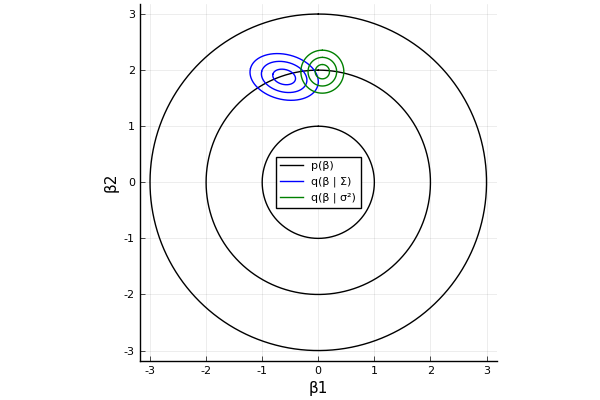

In [18]:
p = plot(
    #xlims = (-50, 50),
    #ylims = (-50, 50),
    aspect_ratio=:equal,
    xlabel = "β1",
    ylabel = "β2",
)
plotnormal2d(p, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 3, color = :black, label="p(β)")

μ₀ = model1.β.prior.μ
Σ₀ = model1.β.prior.Σ
μᵦ = model1.β.posterior.μ
Σᵦ = model1.β.posterior.Σ
plotnormal2d(p, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :blue, label="q(β | Σ)")

μ₀ = model2.β.prior.μ
Σ₀ = model2.β.prior.σ² * Matrix(I, 2, 2)
μᵦ = model2.β.posterior.μ
Σᵦ = model2.β.posterior.σ² * Matrix(I, 2, 2)
plotnormal2d(p, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :green, label="q(β | σ²)")

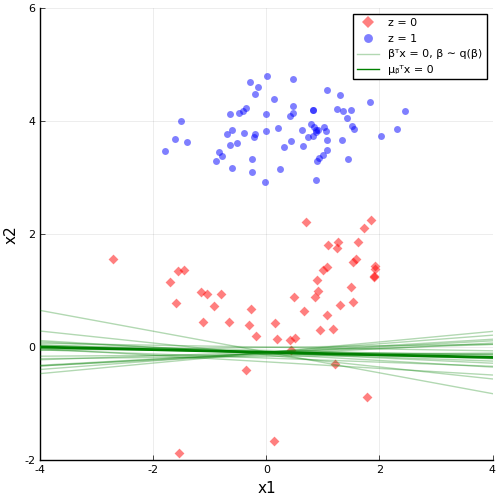

In [264]:
model = model2

μᵦ = model2.β.posterior.μ
Σᵦ = model2.β.posterior.σ² * Matrix(I, 3, 3)

pdec = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-4, 4),
    ylims=(-2, 6),
    xlabel="x1", 
    ylabel="x2"
)

scatter!(pdec,
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, 0.5, stroke(0))
)

scatter!(pdec,
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, 0.5, stroke(0)), 
)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

pdec

In [265]:
model.hasbias

true

In [266]:
1 / model2.β.posterior.σ²

59.31457627311606

In [267]:
tr(inv(model1.β.posterior.Σ)) / 3

59.314576273116096

In [17]:
a = randn(3)
b = randn(3)

a' * b * b' * a, (a' * b)^2

(0.5036397276265469, 0.503639727626547)

(μ = [0.12335468525342103, 1.9805797879318954, 0.16342523860756228], σ² = 0.016342523860756228)

In [42]:
X̂ = regressors(true, X)
m, v = stdparam(model2.β.posterior)

X̂ᵀX̂ = sum(X̂ .* X̂, dims = 1)
mᵀX̂ = m' * X̂
E_ψ² = dropdims(v * X̂ᵀX̂ .+ (mᵀX̂) .^ 2, dims = 1)

120-element Array{Float64,1}:
 37.02922783756876
  3.026985306024455
  3.742652924555553
  0.043689706781179324
  1.185226657308645
  2.7142625361642723
 16.954411190905265
  3.830220455371634
  0.22351100120393358
  4.095362384820177
  6.549173999343719
 14.637998897892382
 15.918894766952887
  ⋮
 80.5911565559505
 59.90304036905457
 75.23638053367667
 81.69664852562617
 64.27854076833701
 85.67470290314941
 69.12273928361024
 59.86590338667595
 78.77859065213337
 61.7939570378095
 45.90245702554215
 72.05352106166265

In [53]:
ψ = dropdims(m' * X̂, dims=1)

(z .- 0.5) .* ψ - 0.5 * E_ψ²

120-element Array{Float64,1}:
 -21.5462621719639
  -2.378382922201216
  -2.8307091189490365
  -0.10297775512134313
  -1.1313246447220824
  -2.1770178058797436
 -10.529422768567398
  -2.8860246463654597
   0.10317158826397224
  -3.054806084584503
  -4.541857024657243
  -9.226819732173286
  -9.946813138550572
   ⋮
 -35.81648188596946
 -26.090092382165107
 -33.290657223356234
 -36.33897430001197
 -28.139352881850574
 -38.21965488967909
 -30.41313345342785
 -26.07259093468324
 -34.960996973896826
 -26.974945527153245
 -19.570961101594268
 -31.792122804329747